In [72]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from Wiki_Hurricane_Scraper import *
from YouTube_Analytics import *
from FEMA_Scraper import *
from NOAA_Scraper import *


pltWidth, pltHeight = 20, 10
plt.rcParams['figure.figsize'] = (pltWidth, pltHeight)

In [63]:
def getDisasterInfo():
    hurricaneDf = getHurricaneData()
    hurricaneDf = hurricaneDf[hurricaneDf['Season'] >= 2005].set_index("Name")
    name = hurricaneDf.index.tolist()
    season = hurricaneDf['Season'].tolist()
    locations = getAllLocations()
    disastersInfo = list(zip(name, season))
    return hurricaneDf, disastersInfo, name, locations

def getFundingDf(funding, disastersInfo, name, locations):
    fundingdf = pd.DataFrame(columns=['Year'] + locations, index=name)
    for hurricane, locs in funding.items():
        for loc, funds in locs.items():
            fundingdf.at[hurricane, loc] = funds
    for name, year in disastersInfo:
        fundingdf.at[name, 'Year'] = year 
    fundingdf.rename(index=str, columns={"- Any -":"Total"}, inplace=True)
    return fundingdf

def getYoutubeDFs(disastersinfo):
    return getAllDisasterDfs(disastersInfo)

def getNOAAFunding(kwargs):
    return getFundingDataFromNOAA(**kwargs)

def processTweetDf(file):
    df = pd.read_csv(file)
    df['Total Exposure'] = df[['replies', 'retweets', 'likes']].sum(axis=1)
    df.drop(['link', 'id', 'location'], axis=1, inplace=True)
    return df

def processYoutubeDf(file):
    df = pd.read_csv(file, index_col=0).reset_index().drop('index', axis=1)
    df.drop(['Favourite Count', 'Video ID'], axis=1, inplace=True)
    return df

def getCompiledDf(fundingDf, hurricaneDf, tweets_by_hurricane, youtube_by_hurricane):
    columns = ['Tweet Count', 'Tweet Exposure', 'Hashtags', 'Video Count', 'Video Exposure',
                   'Youtube Tags']
    num_rows = len(tweets_by_hurricane)
    compiledDf = pd.DataFrame(columns=columns, index=hurricaneNames)
    compiledDf = compiledDf.merge(fundingDf[['Total']], how='outer', left_index=True, right_index=True)
    compiledDf.rename(index=str, columns={"Total":"Funding"}, inplace=True)
    compiledDf = compiledDf.merge(hurricaneDf[['Damages']], how='outer', left_index=True, right_index=True)
    for hurricane in hurricaneNames:
        if hurricane in tweets_by_hurricane:
            tweets = tweets_by_hurricane[hurricane]
            compiledDf.loc[hurricane, 'Tweet Count'] = len(tweets)
            compiledDf.loc[hurricane, 'Tweet Exposure'] = sum(tweets['Total Exposure'])
            allhashes = [val.replace('\'', '') for res in tweets['hashtags'] if res != '[]' \
                                                 for val in res.replace('[', '').replace(']', '').split(', ')]
            compiledDf.loc[hurricane, 'Hashtags'] = ','.join(allhashes)
        vids = youtube_by_hurricane[hurricane]
        compiledDf.loc[hurricane, 'Video Count'] = len(vids)
        compiledDf.loc[hurricane, 'Video Exposure'] = sum(vids['Views'])
        allTags = [val.replace('\'', '') for res in vids['Tags'] if res != '[]' \
                                                 for val in res.replace('[', '').replace(']', '').split(', ')]
        compiledDf.loc[hurricane, 'Youtube Tags'] = ','.join(allTags)
    return compiledDf

In [64]:
searchParamsFema = {'source' : 'https://www.fema.gov/disasters',
                'location' : 'Florida',
                'incidentType' : 'Hurricane',
                'declarationType' : 'DR',
                'startMonth' : 'January',
                'startYear' : 2013,
                'endMonth' : 'December',
                'endYear' : 2018,
                'disasterName' : 'Irma'}

searchQueryNOAA = {
    'eventType': '(Z) Storm Surge/Tide',
    'beginDate_mm': '01',
    'beginDate_dd': '01',
    'beginDate_yyyy': '2013',
    'endDate_mm': '12',
    'endDate_dd': '30',
    'endDate_yyyy': '2018',
    'county': 'ALL',
}

hurricaneDf, disastersInfo, hurricaneNames, locations = getDisasterInfo()

# funding = getAllFunding(disastersInfo, searchParamsFema)
# np.save("fundingDict.npy", funding)

### Collect The Fema Funds as a CSV File
# funding = np.load('fundingDict.npy').item()
# df = getFundingDf(funding, disastersInfo, hurricaneNames, locations)
# df.to_csv('fundingRaised.csv')

### Collect Youtube Stats as CSV file
# YouTubeDictDfs = getYouTubeDfs(disastersInfo)
# for idx, (key, value) in enumerate(YouTubeDictDfs.items()):
#     value.to_csv('YouTube Dataframes/'+key+'.csv')

In [65]:
### LOAD FUNDING DATAFRAME
fundingDf = pd.read_csv('fundingRaised.csv', index_col=0)
fundingDf.drop([col for col, val in fundingDf.sum().iteritems() if val == 0], axis=1, inplace=True)

### LOAD ALL TWEET DATAFRAMES
tweets_by_hurricane = {}
for file in os.listdir("tweet_csv"):
    hurricane = file.split('.')[0]
    tweets_by_hurricane[hurricane] = processTweetDf('tweet_csv/' + file)
    
### LOAD ALL YOUTUBE DATAFRAMES
youtube_by_hurricane = {}
for file in os.listdir("Youtube_Dataframes"):
    hurricane = file.split('.')[0]
    youtube_by_hurricane[hurricane] = processYoutubeDf('Youtube_Dataframes/' + file)
    
### Group Relevant Columns Together Across Df's
df = getCompiledDf(fundingDf, hurricaneDf, tweets_by_hurricane, youtube_by_hurricane)

In [ ]:
locs = df['Funding']>100
plotx = np.log(df['Funding'][locs])
ploty = np.log(df['Damages'][locs])
ax = sns.regplot(plotx, ploty) #, fit_reg=False)
a = pd.concat({'x': plotx, 'y': ploty}, axis=1)
for ((i, point), name) in zip(a.iterrows(), df.index[locs]):
    ax.text(point['x']+0.05, point['y']+0.05, name)
plt.show()

In [166]:
def getTweetText(dataframe, stopwords=[]):
    # Get the stopwords in both small and first caps format
    stopwords = sum(map(lambda x: [x[0].lower() + x[1:], x[0].upper() + x[1:]], stopwords), [])
    
    all_tweets = ' '.join(dataframe.tweet.tolist())
    for stopword in stopwords:
        all_tweets = all_tweets.replace(stopword, '')
    return all_tweets

def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

def getTweetHashtags(dataframe, stopwords=[]):
    all_tweet_tags = ' '.join(dataframe.hashtags.tolist())
    stopwords += ["'", '[', ']', ',', '#', '  ']
    replace_dict = {k: '' for k in stopwords}
    for stopword in stopwords:
        replace_dict[stopword] = ''
    all_tweet_tags = replace_all(all_tweet_tags, replace_dict)
    return all_tweet_tags

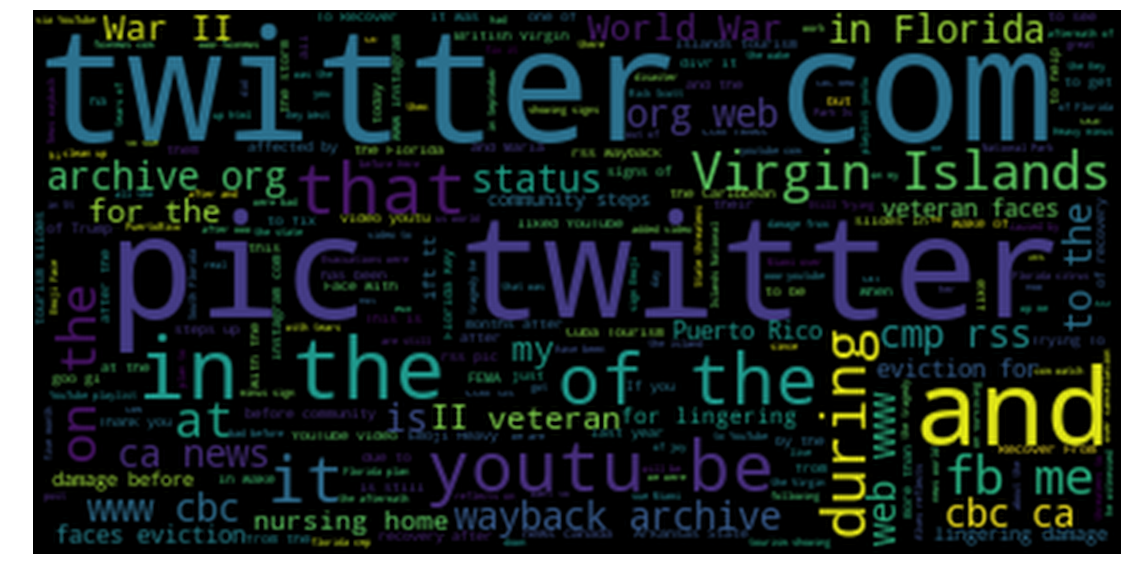

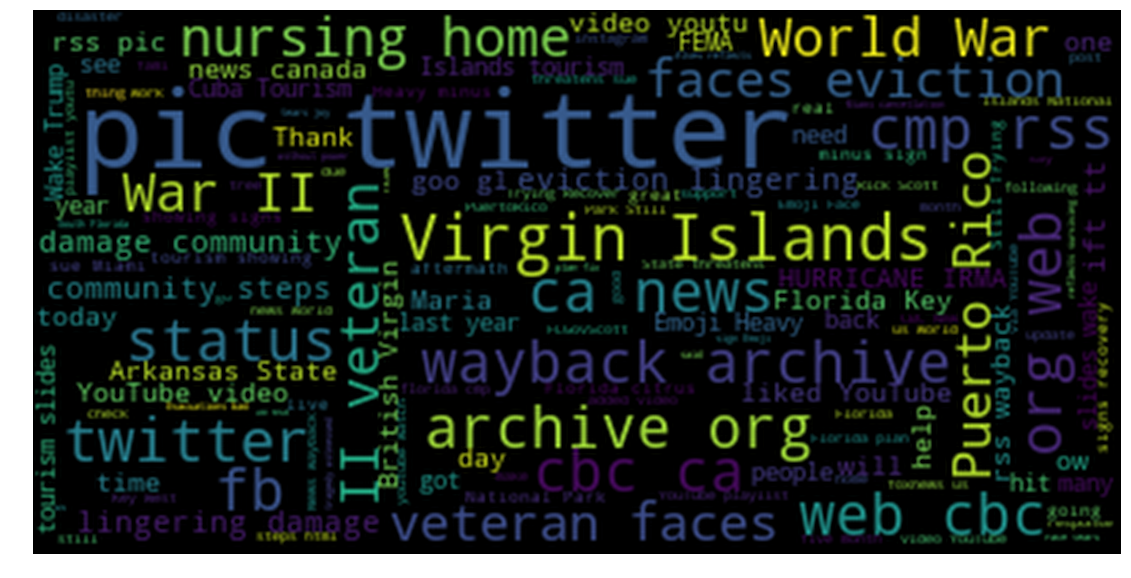

In [169]:
# Read the whole text.
# text = ' '.join(tweets_by_hurricane['Irma'].hashtags).replace('Hurricane', '').replace('hurricane', '').replace('Irma', '')
# text = ' '.join(getTweetHashtags(tweets_by_hurricane['Irma'], []).split(' '))
text = getTweetText(tweets_by_hurricane['Irma'], ['hurricane', 'irma', 'http', 'https', 'bit', 'ly'])

# Generate a word cloud image
wordcloud = WordCloud(background_color="black", max_words=500, stopwords=['hurricane', 'irma']).generate(text)

plt.imshow(wordcloud, interpolation='bessel')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bessel")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

In [ ]:
### Adjusting Funding and Damages for Inflation at an average of 1.89% per year [CITE THIS]
inflationAdjustedDf = df.copy()
def calcInflation()